In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
import cv2
import numpy as np
import math
import glob
import csv
import os
import matplotlib.pyplot as plt
from skimage.exposure import histogram
from matplotlib.pyplot import bar
from skimage.feature import local_binary_pattern
from skimage import io ,filters
from mpl_toolkits.mplot3d import Axes3D

In [3]:
def show_images(images,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        plt.axis('off')
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()

In [4]:
def Preprocess(image):
    
    # Reading Images
#     img = cv2.imread(filename,0) 

    
    # Remove salt and pepper noise    
    # Remove noise 
    median = cv2.medianBlur(image,5)
    blur = cv2.GaussianBlur(image,(5,5),0)
   
    greyImg = image
    
    # Otsu's Binarization
    ret3,img = cv2.threshold(image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
   
    # Remove header and footer
    length, width = img.shape
    up, down, left, right = 0, length - 1, 0, width - 1

    minWidthOfLines = width/2
    contours,__ = cv2.findContours(img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    for i in contours:
        x, y, w, h = cv2.boundingRect(i)
        if w < minWidthOfLines:
            continue
        if y < length // 2:
            up = max(up, y + 15)
        else:
            down = min(down, y - 15)

    offset = 30
    left = left + offset
    right = right -offset
    noHeaderAndFooter = img[up:down + 1, left:right + 1]
    noHeaderAndFooter = np.asarray(noHeaderAndFooter)
    
    noHeaderAndFooterGrey = greyImg[up:down + 1, left:right + 1]
    noHeaderAndFooterGrey = np.asarray(noHeaderAndFooterGrey) 
   
    # To crop the image
    row, col = noHeaderAndFooter.shape
    tolerance = 5

    sumOfRows = np.sum(noHeaderAndFooter, axis = 1)
    rowIndices = np.where(sumOfRows< (col-tolerance)*255)
    up = np.min(rowIndices)
    down = np.max(rowIndices)

    sumOfColoumns = np.sum(noHeaderAndFooter, axis = 0)
    colIndices = np.where(sumOfColoumns< (row-tolerance)*255)
    left = np.min(colIndices)
    right = np.max(colIndices)

    binarized = noHeaderAndFooter[up:down + 1, left:right + 1]
    binarized = np.asarray(binarized)
    
    greyscale = noHeaderAndFooterGrey[up:down + 1, left:right + 1]
    greyscale = np.asarray(greyscale)
   
    # Segmentation of Lines
    rowIndicesShifted = np.roll(rowIndices, -1)
    rowIndicesShifted = rowIndicesShifted[0]

    transitionIndices = np.where(np.abs(rowIndices - rowIndicesShifted) > 10)
    transitionIndices = transitionIndices[1]

    rowIndices = rowIndices[0]

    downIndices= rowIndices[transitionIndices]

    transitionIndicesUp = np.insert(transitionIndices,0,-1)
    transitionIndicesUp = np.delete(transitionIndicesUp,-1)

    upIndices= rowIndices[transitionIndicesUp+1]
    
    segmentsBinarized = []
    segmentsGrey = []
    for i in range(transitionIndices.shape[0]):
        segmentsBinarized.append(noHeaderAndFooter[upIndices[i]:downIndices[i] + 1, left:right + 1])
        segmentsGrey.append(noHeaderAndFooterGrey[upIndices[i]:downIndices[i] + 1, left:right + 1])   
    
#     show_images([greyscale,binarized])
#     show_images(segmentsBinarized)
#     show_images(segmentsGrey)
    
    return greyscale, binarized, segmentsBinarized, segmentsGrey

In [6]:
def showHist(imgHist):
#     plt.figure()
#     n_bins = int(img.max() + 1)
#     imgHist = histogram(img, n_bins)
#     print(imgHist[0])
    bar(imgHist[1].astype(np.uint8), imgHist[0], width=0.8, align='center')
    return imgHist[0]

In [69]:
#  Feature Extraction LBP
def LBP(greyscale):
    lbp = local_binary_pattern(greyscale, 8, 3, method='uniform')
#     plt.figure()
#     plt.imshow(lbp)
    n_bins = int(lbp.max() + 1)
    imgHist = histogram(lbp, n_bins)
#     hist = showHist(imgHist)
    
    return imgHist[0];

In [70]:
def extract_features(greyscale1, binarized1, segmentsBinarized1, segmentsGrey1):
    return LBP(greyscale1)

In [71]:
def train(folder):
    feature_vector_all=[]
    direcs = glob.glob (folder+"/*")
    for direc in direcs:
        if os.path.isdir(direc):
            print(direc)
            files = glob.glob (direc+'/*')
            for file in files:
                #reading an imag
                print("-----------------------",file,"------------------------------")
                img = cv2.imread(file,0) 

                #converting it to a gray image
                #binarization process
                greyscale1, binarized1, segmentsBinarized1, segmentsGrey1 = Preprocess(img)

                feature_vector=[]
                feature_vector.append(int(direc[8]))
                
                hist1 = extract_features(greyscale1, binarized1, segmentsBinarized1, segmentsGrey1)

#                 hist1 = LBP(greyscale1)
                feature_vector.extend(hist1)
                feature_vector_all.append(feature_vector)


    # opening the csv file in 'w+' mode 
    file = open('dataset.csv', 'w+', newline ='') 

    # writing the data into the file 
    with file:
            write = csv.writer(file) 
            write.writerows(feature_vector_all) 

    return feature_vector_all

In [72]:
def calculateDistance(x1, x2):

    distance =np.linalg.norm(x1-x2)
    return distance

# def KNN(test_point, training_features, labels, k): 
#     y= labels[ np.argsort(calculateDistance(test_point,training_features))[:k]]
#     l,h = np.unique(y, return_counts=True)
#     return l[np.argmax(h)]

#     distarr=[]
#     for i in range (training_features.shape[0]):
#         f=calculateDistance(training_features[i,:],test_point)
#         distarr.append(f)
        
        
#     sortedarr=np.sort(distarr)
    
#     classes=np.zeros(3)
    
#     for i in range(k):
#         result = np.where(distarr == sortedarr[i])
#         print(result)
#         for j in range(3):
#             if(labels[result[0]]==j+1):
#                 classes[j]+=1
            
            
#     classification=np.argmax(classes)

  
#     return classification+1




In [73]:
def KNN(test_point, training_features, y_train, k):
   
    class1=0
    class2=0
    class3=0
    dist=[]
    indexs=[]
    print(test_point.shape)
    print(training_features[0].shape)
    
    for i in range(6):
        dist.append(calculateDistance(test_point,training_features[i]))
        
    dist2=np.argsort(dist)

 
    for i in range(k):
        if(y_train[dist2[i]]==1):
            class1=class1+1
        elif(y_train[dist2[i]]==2):
            class2=class2+1
        else:
            class3=class3+1

    if(max(class1,class2,class3)==class1):
        classification=1
    elif(max(class1,class2,class3)==class2):
        classification=2
    else:
        classification=3
    return classification

In [74]:
def read_data(file_name):
 
    data = np.genfromtxt(file_name, delimiter=',')
    return data

def get_feature_vector(img):
    feature_vector=[]
   
    feature_vector.append()
   
    return feature_vector

In [75]:
# Main

# img_original = cv2.imread('01/1/a01-000u.png')
# show_images([img_original])
# print(img.max())


training_data = train("data/01")
# print(training_data)
# training_data = read_data('dataset.csv')

training_data = np.asarray(training_data)

labels = training_data[:,0]
training_features = training_data[:,1:]


data/01\1
----------------------- data/01\1\a01-000u.png ------------------------------
----------------------- data/01\1\a01-003u.png ------------------------------
data/01\2
----------------------- data/01\2\d06-041.png ------------------------------
----------------------- data/01\2\d06-060.png ------------------------------
data/01\3
----------------------- data/01\3\d07-100.png ------------------------------
----------------------- data/01\3\d07-102.png ------------------------------


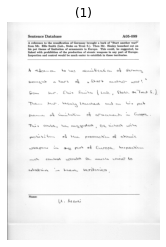

Actual class : 1  of file  01\1_1.png
---------------------------------------
(10,)
(10,)
knn_prediction class : 1


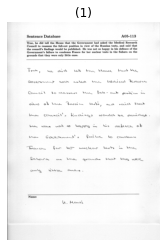

Actual class : 1  of file  01\1_2.png
---------------------------------------
(10,)
(10,)
knn_prediction class : 1


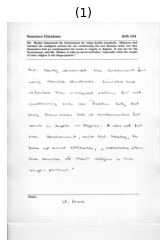

Actual class : 1  of file  01\1_3.png
---------------------------------------
(10,)
(10,)
knn_prediction class : 1


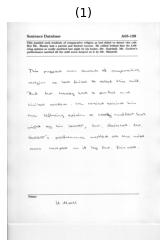

Actual class : 1  of file  01\1_4.png
---------------------------------------
(10,)
(10,)
knn_prediction class : 1


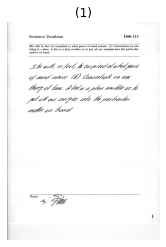

Actual class : 2  of file  01\2_1.png
---------------------------------------
(10,)
(10,)
knn_prediction class : 1


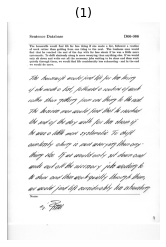

Actual class : 2  of file  01\2_2.png
---------------------------------------
(10,)
(10,)
knn_prediction class : 1


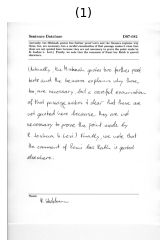

Actual class : 3  of file  01\3_1.png
---------------------------------------
(10,)
(10,)
knn_prediction class : 3


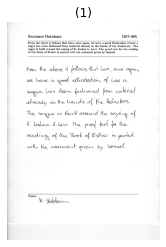

Actual class : 3  of file  01\3_2.png
---------------------------------------
(10,)
(10,)
knn_prediction class : 3


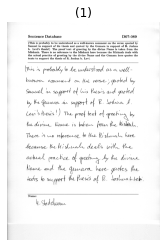

Actual class : 3  of file  01\3_3.png
---------------------------------------
(10,)
(10,)
knn_prediction class : 1


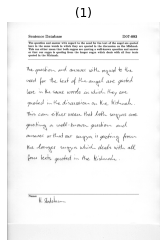

Actual class : 3  of file  01\3_4.png
---------------------------------------
(10,)
(10,)
knn_prediction class : 3


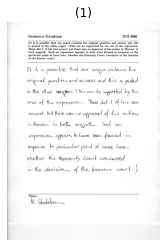

Actual class : 3  of file  01\3_5.png
---------------------------------------
(10,)
(10,)
knn_prediction class : 2


In [76]:

test_images = sorted(glob.glob('01/*.png'))
true_values = [1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 3]
k = 1
knn_prediction = []

for i in range(len(test_images)):
   
    img_original = cv2.imread(test_images[i],0)
    greyscale1, binarized1, segmentsBinarized1, segmentsGrey1 = Preprocess(img_original)
    test_point = extract_features(greyscale1, binarized1, segmentsBinarized1, segmentsGrey1)
    
    # Visualize each test figure. 
    show_images([img_original])

    # Print the actual class of each test figure. 
    print("Actual class :", true_values[i], " of file ", test_images[i])
    print("---------------------------------------")

    # ------------------------------------------------------------------------------------------------------
    # TODO 21: Calculate the prediction of each classifier (Minimum Distance, Nearest Neighbour, K-Nearest Neighbour)
    knn_prediction.append(KNN(test_point, training_features, labels, k))
    
    print("knn_prediction class :", knn_prediction[i])
    
    # ------------------------------------------------------------------------------------------------------

    


In [77]:
total_predictions =  len(test_images)

correct_knn=0
for i in range(len(test_images)):
    if(true_values[i]==knn_prediction[i]):
        correct_knn=correct_knn+1

accuracy_knn = (correct_knn/total_predictions)*100
# ------------------------------------------------------------------------------------------------------

print("K-Nearest Neighbour Classifier Accuracy: ", accuracy_knn, "%")

K-Nearest Neighbour Classifier Accuracy:  63.63636363636363 %
